In [1]:
import numpy as np
from Utils.discrete_family import discrete_family
from Utils.barrier_affine import solve_barrier_tree, solve_barrier_tree_nonneg, solve_barrier_tree_box_PGD
#from CART import RegressionTree
from scipy.interpolate import interp1d
from scipy.stats import multivariate_normal as mvn
from Utils.plotting import  *
from Utils.simulation_helpers import *
from time import time
import cvxpy as cp

In [55]:
class TreeNode:
    def __init__(self, feature_index=None, threshold=None, pos=None,
                 left=None, right=None, value=None, prev_branch=None,
                 prev_node=None, membership=None, depth=0,
                 randomization=None, sd_rand=1., terminal=None):
        self.feature_index = feature_index  # Index of the feature to split on
        self.threshold = threshold  # Threshold value to split on
        self.pos = pos  # Position (the ascending order) of the split value
        self.left = left  # Left child node
        self.right = right  # Right child node
        self.value = value  # Value for leaf nodes (mean of target values)
        self.prev_branch = prev_branch  # List of (j, s, e) depicting a previous branch
        self.prev_node = prev_node
        self.membership = membership
        self.depth = depth
        self.randomization = randomization
        self.sd_rand = sd_rand
        self.terminal = terminal

class RegressionTree:
    def __init__(self, min_samples_split=2, max_depth=float('inf'),
                 min_proportion=0.2, min_bucket=5):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.root = None
        self.min_proportion = min_proportion
        self.min_bucket = min_bucket
        self.terminal_nodes = []
        self.terminal_parents = []
    def fit(self, X, y, sd=1):
        # sd is std. dev. of randomization
        self.X = X
        self.y = y
        self.n = X.shape[0]
        self.root = self._build_tree(X, y, sd=sd)
        #print("Fit sd:", sd)

    def _build_tree(self, X, y, depth=0, membership=None,
                    prev_branch=None, sd=1.):
        #print("Build tree sd:", sd)
        """
        A recursive private function to build the tree
        by repeatedly splitting
        :param X: the covariates of the previous sub-region
        :param y: the response of the previous sub-region
        :param depth: depth of the previous split
        :param sd: std. dev. of randomization
        :return: a node characterizing this split and fitted value
        """
        num_samples, num_features = X.shape
        if depth == 0:
            membership = np.ones((num_samples,))
        else:
            assert membership is not None

        if prev_branch is None:
            prev_branch = []
            # print("pbc:", prev_branch)

        if num_samples >= max(self.min_samples_split, 2) and depth < self.max_depth:
            best_split = self._get_best_split(X, y, num_features, sd_rand=sd)
            if "feature_index" not in best_split.keys():
                print(best_split)
                print(X)
            feature_idx = best_split["feature_index"]
            threshold = best_split["threshold"]
            pos = best_split["position"]
            left_mbsp = self.X[:, feature_idx] <= threshold
            right_mbsp = self.X[:, feature_idx] > threshold
            left_mbsp = left_mbsp * membership  # n x 1 logical vector
            right_mbsp = right_mbsp * membership  # n x 1 logical vector
            # if best_split["gain"] > 0:
            left_prev_branch = prev_branch.copy()
            left_prev_branch.append([feature_idx, pos, 0])
            right_prev_branch = prev_branch.copy()
            right_prev_branch.append([feature_idx, pos, 1])
            # print(left_prev_branch)
            # print(right_prev_branch)
            left_subtree \
                = self._build_tree(best_split["X_left"],
                                   best_split["y_left"],
                                   depth + 1,
                                   membership=left_mbsp,
                                   prev_branch=left_prev_branch,
                                   sd=sd)
            right_subtree \
                = self._build_tree(best_split["X_right"],
                                   best_split["y_right"],
                                   depth + 1,
                                   membership=right_mbsp,
                                   prev_branch=right_prev_branch,
                                   sd=sd)

            leaf_value = self._calculate_leaf_value(y)
            cur_node = TreeNode(value=leaf_value,
                                feature_index=best_split["feature_index"],
                                threshold=best_split["threshold"],
                                pos=pos,
                                left=left_subtree, right=right_subtree,
                                membership=membership, depth=depth,
                                randomization=best_split["randomization"],
                                prev_branch=prev_branch,
                                sd_rand=sd, terminal=False)
            # Add this parent node to subnodes
            left_subtree.prev_node = cur_node
            right_subtree.prev_node = cur_node
            if left_subtree.terminal and right_subtree.terminal:
                #print(cur_node.threshold)
                self.terminal_parents.append(cur_node)
            return cur_node
        leaf_value = self._calculate_leaf_value(y)
        cur_node = TreeNode(value=leaf_value, membership=membership,
                            sd_rand=sd, depth=depth, terminal=True)
        self.terminal_nodes.append(cur_node)
        return cur_node

    def _get_best_split(self, X, y, num_features, sd_rand=1):
        """
        Input (X, y) of a (potentially sub-)region, return information about
        the best split on this regions
        Assuming no ties in features
        :param X: the (sub-)region's covariates
        :param y: the (sub-)region's response
        :param num_features: dimension of X
        :return: a dictionary containing
                {split_feature_idx, (numerical) splitting_threshold,
                split_position, left_sub_region, right_sub_region,
                gain}
        """
        best_split = {}
        min_loss = float('inf')
        num_sample = X.shape[0]
        randomization = np.zeros((num_sample - 1, num_features))
        min_proportion = self.min_proportion
        # Override min_proportion if min_bucket is set
        if self.min_bucket is not None:
            start = self.min_bucket
            end = num_sample - self.min_bucket - 1
        else:
            start = int(np.floor(num_sample * min_proportion))
            end = num_sample - int(np.ceil(num_sample * min_proportion)) - 1
        #print(start, end)
        #print("Get best split sd:", sd_rand)

        for feature_index in range(num_features):
            feature_values = X[:, feature_index]
            feature_values_sorted = feature_values.copy()
            feature_values_sorted.sort()
            #for i in range(len(feature_values_sorted) - 1):
            for i in range(start, end):
                threshold = feature_values_sorted[i]
                X_left, y_left, X_right, y_right = self._split(X, y, feature_index, threshold)
                if len(X_left) > 0 and len(X_right) > 0:
                    #print("entered 1")
                    if sd_rand != 0:
                        omega = np.random.normal(scale=sd_rand)
                    else:
                        omega = 0
                    randomization[i, feature_index] = omega
                    loss = self._calculate_loss(y_left, y_right, omega)
                    if loss < min_loss:
                        #print("entered 2")
                        best_split["feature_index"] = feature_index
                        best_split["threshold"] = threshold
                        best_split["position"] = i
                        best_split["X_left"] = X_left
                        best_split["y_left"] = y_left
                        best_split["X_right"] = X_right
                        best_split["y_right"] = y_right
                        best_split["loss"] = loss
                        best_split["randomization"] = randomization
                        # best_split[""]
                        min_loss = loss
        return best_split

    def _split(self, X, y, feature_index, threshold):
        left_mask = X[:, feature_index] <= threshold
        right_mask = X[:, feature_index] > threshold
        return X[left_mask], y[left_mask], X[right_mask], y[right_mask]

    def _calculate_information_gain(self, y, y_left, y_right):
        var_total = np.var(y) * len(y)
        var_left = np.var(y_left) * len(y_left)
        var_right = np.var(y_right) * len(y_right)
        return var_total - (var_left + var_right)

    def _calculate_loss(self, y_left, y_right, randomization):
        n1 = len(y_left)
        n2 = len(y_right)
        n = n1 + n2
        """loss = ((np.var(y_left) * n1 + np.var(y_right) * np.sqrt(n2)) / np.sqrt(n1 + n2)
                + randomization)"""
        loss = ( (- n1 * np.mean(y_left) ** 2 - n2 * np.mean(y_right) ** 2) / np.sqrt(n)
                + randomization)
        # Actually need not divide by n1+n2...
        #print("loss:", loss - randomization)
        #print("randomization:", randomization)
        return loss

    #
    def _calculate_leaf_value(self, y):
        """
        :param y: the response of the previous sub-region
        :return: the mean of the region
        """
        return np.mean(y)

    def predict(self, X):
        """
        :param X: the test dataset
        :return: fitted values
        """
        return np.array([self._predict(sample, self.root) for sample in X])

    def _predict(self, sample, tree):
        """
        Recursively searching the tree for the surrounding region of `sample`
        :param sample: the input covariates
        :param tree: the trained tree
        :return: fitted y value of `sample`
        """
        if tree.terminal:
            return tree.value
        feature_value = sample[tree.feature_index]
        if feature_value <= tree.threshold:
            return self._predict(sample, tree.left)
        else:
            return self._predict(sample, tree.right)

    def _approx_log_reference(self, node, grid, nuisance,
                              contrast, norm_contrast, sd=1, sd_rand=1):
        ## TODO: 0. grid is a grid for eta'Y / (sd * norm_contrast);
        ##          first reconstruct eta'Y and then reconstruct Q
        ## TODO: 1. reconstruct Q from the grid
        ## TODO: 2. Perform Laplace approximation for each grid,
        #           and for each node split
        ## TODO: 3. Add back the constant term omitted in Laplace Approximation
        ## TODO: 4. Return reference measure

        prev_branch = node.prev_branch.copy()
        current_depth = node.depth
        ref_hat = np.zeros_like(grid)

        ## TODO: Move the node according to branch when evaluating integrals
        node = self.root

        # norm = np.linalg.norm(contrast)
        depth = 0

        while depth <= current_depth:
            for g_idx, g in enumerate(grid):
                y_grid = g * sd ** 2 * norm_contrast + nuisance
                # TODO: Account for depth here
                # Subsetting the covariates to this current node
                X = self.X[node.membership.astype(bool)]
                y_g = y_grid[node.membership.astype(bool)]
                y_node = self.y[node.membership.astype(bool)]
                y_left = y_grid[node.left.membership.astype(bool)]
                y_right = y_grid[node.right.membership.astype(bool)]
                y_left_obs = self.y[node.left.membership.astype(bool)]
                y_right_obs = self.y[node.right.membership.astype(bool)]
                optimal_loss = self._calculate_loss(y_left, y_right,
                                                    randomization=0)
                opt_loss_obs = self._calculate_loss(y_left_obs, y_right_obs,
                                                    randomization=0)
                j_opt = node.feature_index  # j^*
                s_opt = node.pos  # s^*
                randomization = node.randomization
                S_total, J_total = randomization.shape
                implied_mean = []
                observed_opt = []



                # TODO: Add a layer to account for depth of the tree
                for j in range(J_total):
                    feature_values = X[:, j]
                    feature_values_sorted = feature_values.copy()
                    feature_values_sorted.sort()
                    for s in range(S_total - 1):
                        if not (j == j_opt and s == s_opt):
                            threshold = feature_values_sorted[s]
                            X_left, y_left, X_right, y_right \
                                = self._split(X, y_g, j, threshold)
                            implied_mean_s_j \
                                = optimal_loss - self._calculate_loss(y_left,
                                                                      y_right,
                                                                      randomization=0)
                            # The split of the actually observed Y
                            X_left_o, y_left_o, X_right_o, y_right_o \
                                = self._split(X, y_node, j, threshold)
                            # print(y_left_o.shape)
                            # print(y_right_o.shape)
                            observed_opt_s_j = (opt_loss_obs -
                                                self._calculate_loss(y_left_o,
                                                                     y_right_o,
                                                                     randomization=0)
                                                + (randomization[s_opt, j_opt] -
                                                   randomization[s, j]))
                            # print("s:", s, "j:", j, "sopt:", s_opt, "jopt:", j_opt)

                            # Record the implied mean
                            # and observed optimization variable
                            implied_mean.append(implied_mean_s_j)
                            observed_opt.append(observed_opt_s_j)

                # The implied mean is given by the optimal loss minus
                # the loss at each split
                implied_mean = np.array(implied_mean)
                observed_opt = np.array(observed_opt)
                # print(observed_opt)
                assert np.max(observed_opt) < 0

                # dimension of the optimization variable
                n_opt = len(implied_mean)
                implied_cov = np.ones((n_opt, n_opt)) + np.eye(n_opt)
                prec = (np.eye(n_opt) - np.ones((n_opt, n_opt))
                        / ((n_opt + 1))) / (sd_rand ** 2)

                # TODO: what is a feasible point?
                # TODO: Need to have access to the observed opt var
                #       where we actually pass in g = eta'Y.
                # print("Implied mean", implied_mean)
                # print("feasible point", observed_opt)
                # print("prec", prec)
                # Approximate the selection probability
                sel_prob, _, _ = solve_barrier_tree_nonneg(Q=implied_mean,
                                                           precision=prec,
                                                           feasible_point=None)
                const_term = (implied_mean).T.dot(prec).dot(implied_mean) / 2
                ref_hat[g_idx] += (- sel_prob - const_term)
                print("conjugate norm:", np.linalg.norm(prec.dot(implied_mean)))

            # Move to the next layer
            if depth < current_depth:
                dir = prev_branch[depth][2]
                if dir == 0:
                    node = node.left  # Depend on where the branch demands
                else:
                    node = node.right
                depth += 1
            else:
                depth += 1  # Exit the loop if targeting depth achieved
        
        return np.array(ref_hat)

    def _condl_approx_log_reference(self, node, grid, nuisance,
                                    norm_contrast, sd=1, sd_rand=1,
                                    reduced_dim=5, use_CVXPY=True):
        ## TODO: 0. grid is a grid for eta'Y / (sd * ||contrast||_2);
        ##          first reconstruct eta'Y and then reconstruct Q
        ## TODO: 1. reconstruct Q from the grid
        ## TODO: 2. Perform Laplace approximation for each grid,
        #           and for each node split
        ## TODO: 3. Add back the constant term omitted in Laplace Approximation
        ## TODO: 4. Return reference measure

        r_is_none = reduced_dim is None

        def k_dim_prec(k, sd_rand):
            prec = (np.eye(k) - np.ones((k, k))
                    / ((k + 1))) / (sd_rand ** 2)
            #print("Precision (k-dim):", prec)
            #print("SD_rand:", sd_rand)
            return prec

        def get_cond_dist(mean, cov, cond_idx, rem_idx, rem_val,
                          sd_rand, rem_dim):
            prec_rem = k_dim_prec(k=rem_dim, sd_rand=sd_rand)

            cond_mean = mean[cond_idx] + cov[np.ix_(cond_idx, rem_idx)].dot(prec_rem).dot(rem_val - mean[rem_idx])
            cond_cov = cov[np.ix_(cond_idx, cond_idx)] - cov[np.ix_(cond_idx, rem_idx)].dot(prec_rem).dot(
                cov[np.ix_(rem_idx, cond_idx)])
            cond_prec = np.linalg.inv(cond_cov)

            return cond_mean, cond_cov, cond_prec

        def get_log_pdf(observed_opt, implied_mean, rem_idx, sd_rand, rem_dim):
            x = observed_opt[rem_idx]
            mean = implied_mean[rem_idx]

            """return (-1/2 * (np.linalg.norm(x-mean)**2 - np.sum(x-mean)**2/(rem_dim+1)) / sd_rand**2
                    - (rem_dim/2)* np.log(2*np.pi) - 0.5*(2*rem_dim * np.log(sd_rand) + np.log(rem_dim + 1)))"""
            return (-0.5 * (np.linalg.norm(x-mean)**2 - np.sum(x-mean)**2/(rem_dim+1))
                    / sd_rand**2)

        prev_branch = node.prev_branch.copy()
        current_depth = node.depth
        ref_hat = np.zeros_like(grid)

        node = self.root

        # norm = np.linalg.norm(contrast)
        depth = 0

        while depth <= current_depth:
            # Subsetting the covariates to this current node
            X = self.X[node.membership.astype(bool)]
            j_opt = node.feature_index  # j^*
            s_opt = node.pos  # s^*
            randomization = node.randomization
            S_total, J_total = randomization.shape

            # Sort feature values to get the threshold
            feature_values_sorted = np.zeros_like(X)
            for j in range(J_total):
                feature_values_sorted[:, j] = X[:, j].copy()
                feature_values_sorted[:, j].sort()

            for g_idx, g in enumerate(grid):
                # norm_contrast: eta / (||eta|| * sigma)
                # grid is a grid for eta'y / (||eta|| * sigma)
                y_grid = g * sd ** 2 * norm_contrast + nuisance

                # Reconstructing y
                y_g = y_grid[node.membership.astype(bool)]
                y_node = self.y[node.membership.astype(bool)]
                y_left = y_grid[node.left.membership.astype(bool)]
                y_right = y_grid[node.right.membership.astype(bool)]
                y_left_obs = self.y[node.left.membership.astype(bool)]
                y_right_obs = self.y[node.right.membership.astype(bool)]
                optimal_loss = self._calculate_loss(y_left, y_right,
                                                    randomization=0)
                opt_loss_obs = self._calculate_loss(y_left_obs, y_right_obs,
                                                    randomization=0)

                implied_mean = []
                observed_opt = []

                # Iterate over all covariates
                for j in range(J_total):
                    num_sample = X.shape[0]
                    min_proportion = self.min_proportion
                    # Override min_proportion if min_bucket is set
                    if self.min_bucket is not None:
                        start = self.min_bucket
                        end = num_sample - self.min_bucket - 1
                    else:
                        start = int(np.floor(num_sample * min_proportion))
                        end = num_sample - int(np.ceil(num_sample * min_proportion)) - 1

                    # for s in range(S_total - 1):
                    for s in range(start, end):
                        if not (j == j_opt and s == s_opt):
                            threshold = feature_values_sorted[s,j]
                            X_left, y_left, X_right, y_right \
                                = self._split(X, y_g, j, threshold)
                            implied_mean_s_j \
                                = optimal_loss - self._calculate_loss(y_left,
                                                                      y_right,
                                                                      randomization=0)
                            # The split of the actually observed Y
                            X_left_o, y_left_o, X_right_o, y_right_o \
                                = self._split(X, y_node, j, threshold)
                            # print(y_left_o.shape)
                            # print(y_right_o.shape)
                            observed_opt_s_j = (opt_loss_obs -
                                                self._calculate_loss(y_left_o,
                                                                     y_right_o,
                                                                     randomization=0)
                                                + (randomization[s_opt, j_opt] -
                                                   randomization[s, j]))
                            # print("s:", s, "j:", j, "sopt:", s_opt, "jopt:", j_opt)

                            # Record the implied mean
                            # and observed optimization variable
                            implied_mean.append(implied_mean_s_j)
                            observed_opt.append(observed_opt_s_j)

                # The implied mean is given by the optimal loss minus
                # the loss at each split
                implied_mean = np.array(implied_mean)
                observed_opt = np.array(observed_opt)
                if np.max(observed_opt) >= 0:
                    print(observed_opt)
                assert np.max(observed_opt) < 0

                if r_is_none:
                    reduced_dim = int(len(implied_mean) * 0.05)

                # Get the order of optimization variables in descending order
                obs_opt_order = np.argsort(observed_opt)[::-1]
                # reduced_dim = max(int(0.1*len(implied_mean)), 5)
                top_d_idx = obs_opt_order[0:reduced_dim]
                rem_d_idx = obs_opt_order[reduced_dim:]
                offset_val = observed_opt[obs_opt_order[reduced_dim]]
                # print("LB:", offset_val)

                linear = np.zeros((reduced_dim * 2, reduced_dim))
                linear[0:reduced_dim, 0:reduced_dim] = np.eye(reduced_dim)
                linear[reduced_dim:, 0:reduced_dim] = -np.eye(reduced_dim)
                offset = np.zeros(reduced_dim * 2)
                offset[reduced_dim:] = -offset_val
                # dimension of the optimization variable
                n_opt = len(implied_mean)
                implied_cov = (np.ones((n_opt, n_opt)) + np.eye(n_opt)) * (sd_rand ** 2)
                cond_implied_mean, cond_implied_cov, cond_implied_prec = (
                    get_cond_dist(mean=implied_mean,
                                  cov=implied_cov,
                                  cond_idx=top_d_idx,
                                  rem_idx=rem_d_idx,
                                  rem_val=observed_opt[rem_d_idx],
                                  sd_rand=sd_rand,
                                  rem_dim=n_opt - reduced_dim))

                if use_CVXPY:
                    ### USE CVXPY
                    # Define the variable
                    o = cp.Variable(reduced_dim)
                    # print(n_opt)
                    # print(len(cond_implied_mean))

                    # Objective function: (1/2) * (u - Q)' * A * (u - Q)
                    objective = cp.Minimize(0.5 * cp.quad_form(o - cond_implied_mean,
                                                               cond_implied_prec))
                    # Constraints: con_linear' * u <= con_offset
                    constraints = [o >= offset_val, o <= 0]
                    # print(offset_val)
                    # Problem definition
                    prob = cp.Problem(objective, constraints)
                    # Solve the problem
                    prob.solve()
                    ref_hat[g_idx] += (-prob.value)
                    print("integral:", -prob.value)
                    log_pdf_rem = get_log_pdf(observed_opt=observed_opt,
                                              implied_mean=implied_mean,
                                              rem_idx=rem_d_idx,
                                              sd_rand=sd_rand,
                                              rem_dim=n_opt - reduced_dim)
                    # Add omitted term
                    ref_hat[g_idx] += (log_pdf_rem)
                    print("marginal:", log_pdf_rem)
                else:
                    sel_prob, _, _ = solve_barrier_tree_box_PGD(Q=cond_implied_mean,
                                                                precision=cond_implied_prec,
                                                                lb=offset_val,
                                                                feasible_point=None)
                    const_term = (cond_implied_mean).T.dot(cond_implied_prec).dot(cond_implied_mean) / 2
                    ref_hat[g_idx] += (- sel_prob - const_term)
                    # Add omitted term
                    ref_hat[g_idx] += (get_log_pdf(observed_opt=observed_opt,
                                                   implied_mean=implied_mean,
                                                   rem_idx=rem_d_idx,
                                                   sd_rand=sd_rand,
                                                   rem_dim=n_opt - reduced_dim))

            # Move to the next layer
            if depth < current_depth:
                dir = prev_branch[depth][2]
                if dir == 0:
                    node = node.left  # Depend on where the branch demands
                else:
                    node = node.right
                depth += 1
            else:
                depth += 1  # Exit the loop if targeting depth achieved
        
        ref_hat -= np.max(ref_hat)
        
        return np.array(ref_hat)

    def split_inference(self, node, ngrid=1000, ncoarse=20, grid_width=15,
                        sd=1, level=0.9):
        """
        Inference for a split of a node
        :param node: the node whose split is of interest
        :return: p-values for difference in mean
        """
        # First determine the projection direction
        left_membership = node.left.membership
        right_membership = node.right.membership
        contrast = left_membership / np.sum(left_membership) - right_membership / np.sum(right_membership)
        sd_rand = node.sd_rand

        norm_contrast = contrast / (np.linalg.norm(contrast) * sd)

        # Using the normalized contrast in practice
        # for scale-free grid approximation
        observed_target = norm_contrast @ self.y
        # The nuisance parameter is defined the same way
        # as on papers
        nuisance = (self.y - np.linalg.outer(contrast, contrast)
                    @ self.y / (np.linalg.norm(contrast) ** 2))

        stat_grid = np.linspace(-grid_width, grid_width,
                                num=ngrid)

        if ncoarse is not None:
            coarse_grid = np.linspace(-grid_width, grid_width, ncoarse)
            eval_grid = coarse_grid
        else:
            eval_grid = stat_grid

        # Evaluate reference measure (selection prob.) over stat_grid
        ref = self._approx_log_reference(node=node,
                                         grid=eval_grid,
                                         nuisance=nuisance,
                                         contrast=contrast,
                                         norm_contrast=norm_contrast, sd=1,
                                         sd_rand=sd_rand)

        if ncoarse is None:
            logWeights = np.zeros((ngrid,))
            for g in range(ngrid):
                # Evaluate the log pdf as a sum of (log) gaussian pdf
                # and (log) reference measure
                # TODO: Check if the original exp. fam. density is correct
                logWeights[g] = (- 0.5 * (stat_grid[g]) ** 2 + ref[g])
            # normalize logWeights
            logWeights = logWeights - np.max(logWeights)
            condl_density = discrete_family(eval_grid,
                                            np.exp(logWeights),
                                            logweights=logWeights)
        else:
            # print("Coarse grid")
            approx_fn = interp1d(eval_grid,
                                 ref,
                                 kind='quadratic',
                                 bounds_error=False,
                                 fill_value='extrapolate')
            grid = np.linspace(-grid_width, grid_width, num=ngrid)
            sel_probs = np.zeros((ngrid,))
            logWeights = np.zeros((ngrid,))
            for g in range(ngrid):
                # TODO: Check if the original exp. fam. density is correct
                logWeights[g] = (- 0.5 * (grid[g]) ** 2 + approx_fn(grid[g]))
                sel_probs[g] = approx_fn(grid[g])

            # normalize logWeights
            logWeights = logWeights - np.max(logWeights)

            condl_density = discrete_family(grid, np.exp(logWeights),
                                            logweights=logWeights)

        if np.isnan(logWeights).sum() != 0:
            print("logWeights contains nan")
        elif (logWeights == np.inf).sum() != 0:
            print("logWeights contains inf")
        elif (np.asarray(ref) == np.inf).sum() != 0:
            print("ref contains inf")
        elif (np.asarray(ref) == -np.inf).sum() != 0:
            print("ref contains -inf")
        elif np.isnan(np.asarray(ref)).sum() != 0:
            print("ref contains nan")

        """interval = (condl_density.equal_tailed_interval
                        (observed=contrast.T @ self.y,
                         alpha=1-level))
        if np.isnan(interval[0]) or np.isnan(interval[1]):
            print("Failed to construct intervals: nan")"""

        # TODO: Fix this; pass in observed values
        pivot = condl_density.ccdf(x=observed_target
                                     / (np.linalg.norm(contrast) * sd),
                                   theta=0)

        return (pivot, condl_density, contrast, norm_contrast,
                observed_target, logWeights, sel_probs)

    def condl_split_inference(self, node, ngrid=1000, ncoarse=20, grid_w_const=1.5,
                              sd=1, reduced_dim=5, use_cvxpy=False):
        """
        Inference for a split of a node
        :param node: the node whose split is of interest
        :return: p-values for difference in mean
        """
        # First determine the projection direction
        left_membership = node.left.membership
        right_membership = node.right.membership
        contrast = left_membership / np.sum(left_membership) - right_membership / np.sum(right_membership)
        sd_rand = node.sd_rand

        # Normalized contrast: The inner product norm_contrast'Y has sd = 1.
        norm_contrast = contrast / (np.linalg.norm(contrast) * sd)

        # Using the normalized contrast in practice
        # for scale-free grid approximation
        observed_target = norm_contrast @ self.y
        # The nuisance parameter is defined the same way
        # as on papers
        nuisance = (self.y - np.linalg.outer(contrast, contrast)
                    @ self.y / (np.linalg.norm(contrast) ** 2))

        grid_width = grid_w_const * np.abs(observed_target)

        stat_grid = np.linspace(-grid_width, grid_width, num=ngrid)

        if ncoarse is not None:
            coarse_grid = np.linspace(-grid_width, grid_width, ncoarse)
            eval_grid = coarse_grid
        else:
            eval_grid = stat_grid

        ref = self._condl_approx_log_reference(node=node,
                                               grid=eval_grid,
                                               nuisance=nuisance,
                                               norm_contrast=norm_contrast, sd=sd,
                                               sd_rand=sd_rand,
                                               reduced_dim=reduced_dim,
                                               use_CVXPY=use_cvxpy)

        if ncoarse is None:
            logWeights = np.zeros((ngrid,))
            for g in range(ngrid):
                # Evaluate the log pdf as a sum of (log) gaussian pdf
                # and (log) reference measure
                # TODO: Check if the original exp. fam. density is correct
                logWeights[g] = (- 0.5 * (stat_grid[g]) ** 2 + ref[g])
            # normalize logWeights
            logWeights = logWeights - np.max(logWeights)
            condl_density = discrete_family(eval_grid,
                                            np.exp(logWeights),
                                            logweights=logWeights)
        else:
            # print("Coarse grid")
            approx_fn = interp1d(eval_grid,
                                 ref,
                                 kind='quadratic',
                                 bounds_error=False,
                                 fill_value='extrapolate')
            grid = np.linspace(-grid_width, grid_width, num=ngrid)
            logWeights = np.zeros((ngrid,))
            suff = np.zeros((ngrid,))
            sel_probs = np.zeros((ngrid,))
            for g in range(ngrid):
                # TODO: Check if the original exp. fam. density is correct

                logWeights[g] = (- 0.5 * (grid[g]) ** 2 + approx_fn(grid[g]))
                suff[g] = - 0.5 * (grid[g]) ** 2
                sel_probs[g] = approx_fn(grid[g])

            # normalize logWeights
            logWeights = logWeights - np.max(logWeights)

            # condl_density is a discrete approximation
            # to the exponential family distribution with
            # natural parameter theta := eta'mu / (||eta|| * sigma)
            # and
            # sufficient statistic X := eta'y / (||eta|| * sigma) = norm_contrast'Y
            condl_density = discrete_family(grid, np.exp(logWeights),
                                            logweights=logWeights)

        if np.isnan(logWeights).sum() != 0:
            print("logWeights contains nan")
        elif (logWeights == np.inf).sum() != 0:
            print("logWeights contains inf")
        elif (np.asarray(ref) == np.inf).sum() != 0:
            print("ref contains inf")
        elif (np.asarray(ref) == -np.inf).sum() != 0:
            print("ref contains -inf")
        elif np.isnan(np.asarray(ref)).sum() != 0:
            print("ref contains nan")

        """interval = (condl_density.equal_tailed_interval
                        (observed=contrast.T @ self.y,
                         alpha=1-level))
        if np.isnan(interval[0]) or np.isnan(interval[1]):
            print("Failed to construct intervals: nan")"""

        # TODO: Fix this; pass in observed values
        pivot = condl_density.ccdf(x=observed_target,
                                   theta=0)

        """# Recall: observed_target = norm_contrast @ self.y
        L, U = condl_density.equal_tailed_interval(observed=observed_target,
                                                   alpha=0.1)

        print('CI:', L, ',', U)"""

        return (pivot, condl_density, contrast, norm_contrast,
                observed_target, logWeights, suff, sel_probs)

    def condl_node_inference(self, node, ngrid=1000, ncoarse=20, grid_w_const=1.5,
                             sd=1, reduced_dim=5, use_cvxpy=False):
        """
        Inference for a split of a node
        :param node: the node whose split is of interest
        :return: p-values for difference in mean
        """
        # First determine the projection direction
        membership = node.membership
        contrast = membership / np.sum(membership)
        sd_rand = node.sd_rand
        #print("Inference sd", sd_rand)

        # Normalized contrast: The inner product norm_contrast'Y has sd = 1.
        norm_contrast = contrast / (np.linalg.norm(contrast) * sd)

        # Using the normalized contrast in practice
        # for scale-free grid approximation
        observed_target = norm_contrast @ self.y
        # The nuisance parameter is defined the same way
        # as on papers
        nuisance = (self.y - np.linalg.outer(contrast, contrast)
                    @ self.y / (np.linalg.norm(contrast) ** 2))

        grid_width = grid_w_const * np.abs(observed_target)

        stat_grid = np.linspace(-grid_width, grid_width, num=ngrid)

        if ncoarse is not None:
            coarse_grid = np.linspace(-grid_width, grid_width, ncoarse)
            eval_grid = coarse_grid
        else:
            eval_grid = stat_grid

        ref = self._condl_approx_log_reference(node=node.prev_node,
                                               grid=eval_grid,
                                               nuisance=nuisance,
                                               norm_contrast=norm_contrast, sd=sd,
                                               sd_rand=sd_rand,
                                               reduced_dim=reduced_dim,
                                               use_CVXPY=use_cvxpy)

        if ncoarse is None:
            logWeights = np.zeros((ngrid,))
            for g in range(ngrid):
                # Evaluate the log pdf as a sum of (log) gaussian pdf
                # and (log) reference measure
                # TODO: Check if the original exp. fam. density is correct
                logWeights[g] = (- 0.5 * (stat_grid[g]) ** 2 + ref[g])
            # normalize logWeights
            logWeights = logWeights - np.max(logWeights)
            condl_density = discrete_family(eval_grid,
                                            np.exp(logWeights),
                                            logweights=logWeights)
        else:
            # print("Coarse grid")
            approx_fn = interp1d(eval_grid,
                                 ref,
                                 kind='quadratic',
                                 bounds_error=False,
                                 fill_value='extrapolate')
            grid = np.linspace(-grid_width, grid_width, num=ngrid)
            logWeights = np.zeros((ngrid,))
            suff = np.zeros((ngrid,))
            sel_probs = np.zeros((ngrid,))
            for g in range(ngrid):
                # TODO: Check if the original exp. fam. density is correct

                logWeights[g] = (- 0.5 * (grid[g]) ** 2 + approx_fn(grid[g]))
                suff[g] = - 0.5 * (grid[g]) ** 2
                sel_probs[g] = approx_fn(grid[g])

            # normalize logWeights
            logWeights = logWeights - np.max(logWeights)

            # condl_density is a discrete approximation
            # to the exponential family distribution with
            # natural parameter theta := eta'mu / (||eta|| * sigma)
            # and
            # sufficient statistic X := eta'y / (||eta|| * sigma) = norm_contrast'Y
            condl_density = discrete_family(grid, np.exp(logWeights),
                                            logweights=logWeights)

        if np.isnan(logWeights).sum() != 0:
            print("logWeights contains nan")
        elif (logWeights == np.inf).sum() != 0:
            print("logWeights contains inf")
        elif (np.asarray(ref) == np.inf).sum() != 0:
            print("ref contains inf")
        elif (np.asarray(ref) == -np.inf).sum() != 0:
            print("ref contains -inf")
        elif np.isnan(np.asarray(ref)).sum() != 0:
            print("ref contains nan")

        """interval = (condl_density.equal_tailed_interval
                        (observed=contrast.T @ self.y,
                         alpha=1-level))
        if np.isnan(interval[0]) or np.isnan(interval[1]):
            print("Failed to construct intervals: nan")"""

        # TODO: Fix this; pass in observed values
        pivot = condl_density.ccdf(x=observed_target,
                                   theta=0)

        """# Recall: observed_target = norm_contrast @ self.y
        L, U = condl_density.equal_tailed_interval(observed=observed_target,
                                                   alpha=0.1)

        print('CI:', L, ',', U)"""

        return (pivot, condl_density, contrast, norm_contrast,
                observed_target, logWeights, suff, sel_probs)

    def _delete_children(self, node):
        """
        :param node: The node whose children are to be deleted
        :return:
        """
        node.left = None
        node.right = None
        # Keep track of the terminal nodes
        node.terminal = True


    def bottom_up_pruning(self, level=0.1, sd_y=1):
        temp_term_parents = []
        while self.terminal_parents:
            parent = self.terminal_parents.pop()
            pivot, dist, contrast, norm_contrast, obs_tar, logW, suff, sel_probs = (
                self.condl_split_inference(node=parent,
                                           ngrid=10000,
                                           ncoarse=200,
                                           grid_w_const=10,
                                           reduced_dim=1,
                                           sd=sd_y,
                                           use_cvxpy=True))

            # Prune if the split is insignificant
            if min(pivot, 1-pivot) >= level/2:
                self._delete_children(parent)
                if parent.prev_branch:
                    if parent.prev_branch[-1][2] == 0:
                        neighbor = parent.prev_node.right
                    else:
                        neighbor = parent.prev_node.left
                    # If this parent node's parent is now a terminal parent node
                    # add it to the terminal parents list
                    if neighbor.terminal:
                        self.terminal_parents.append(parent.prev_node)
            else:
                # If the split is significant,
                # preserve it in the temp list
                temp_term_parents.append(parent)

        self.terminal_parents = temp_term_parents


    def print_branches(self, node=None, start=True, depth=0):
        """
        Recursively printing (with proper indentation denoting depth) the tree
        :param node: the node to be printed
        :param start: a logic flag for whether the node is the root
        :param depth: depth of a node to be printed
        """
        if start:
            node = self.root
        if node is None:
            return
        if node.left or node.right:
            print("\t" * depth, "j:", node.feature_index)
            print("\t" * depth, "threshold:", node.threshold)
            if node.left and node.right:
                print("\t" * depth, "left:")
                self.print_branches(node.left, start=False, depth=depth + 1)
                print("\t" * depth, "right:")
                self.print_branches(node.right, start=False, depth=depth + 1)
            elif node.right:
                print("\t" * depth, "left:")
                self.print_branches(node.right, start=False, depth=depth + 1)
            else:
                print("\t" * depth, "right:")
                self.print_branches(node.left, start=False, depth=depth + 1)
        return

    # Example usage:

## Testing Approximate Reference

In [56]:
n = 50
p = 5
np.random.seed(123)
X = np.random.normal(size=(n, p))
a = 1
b = 1

mu = b * ((X[:, 0] <= 0) * (1 + a * (X[:, 1] > 0) + (X[:, 2] * X[:, 1] <= 0)))
sd = 3
noise_sd = 1
y = mu + np.random.normal(size=(n,), scale=sd)
# Create and train the regression tree
reg_tree = RegressionTree(min_samples_split=10, max_depth=2, min_proportion=0)

In [57]:
reg_tree.fit(X, y, sd = noise_sd * sd)

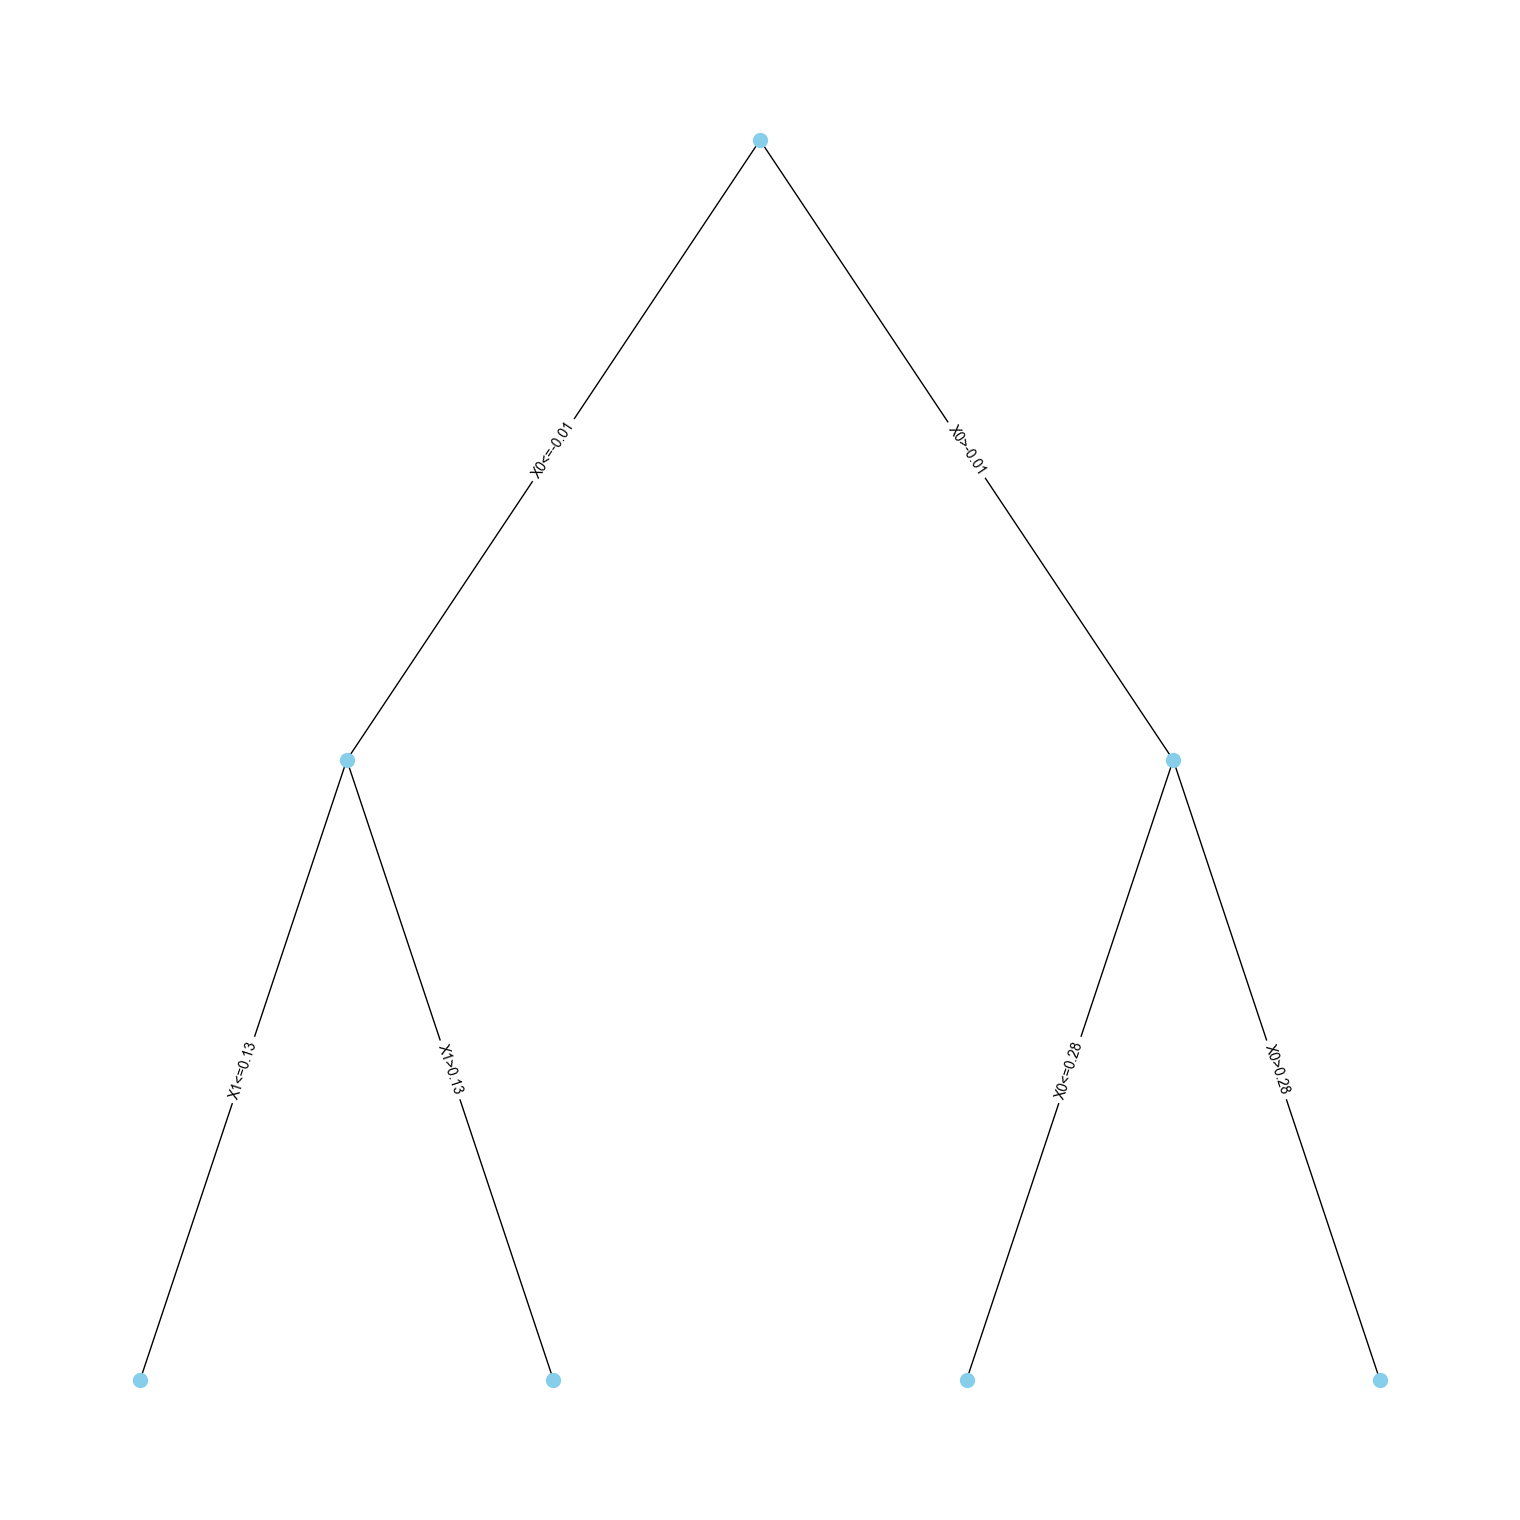

In [58]:
draw_tree(reg_tree.root)

In [59]:
pval, dist, contrast, norm_contrast, obs_tar, logW, suff, sel_probs = (
    reg_tree.condl_node_inference(node=reg_tree.terminal_nodes[0], 
                                   ngrid=10000,
                                   ncoarse=50,
                                   grid_w_const=5,
                                   reduced_dim=None,
                                   sd=sd, use_cvxpy=True))

integral: -126.45500124654222
marginal: -1718.1962790861644
integral: -120.30929983059588
marginal: -1578.9481594730687
integral: -114.3131451492585
marginal: -1449.349868228853
integral: -108.4447058125157
marginal: -1328.8065006579839
integral: -102.68668566939914
marginal: -1216.7510705911668
integral: -97.01777231994075
marginal: -1112.6445103853491
integral: -91.3846885317832
marginal: -1015.9756709237149
integral: -85.7766941809271
marginal: -926.2613216156832
integral: -80.19404565507149
marginal: -843.0461503969304
integral: -74.64153267486672
marginal: -765.9027637293491
integral: -69.12847829391428
marginal: -694.4316866010971
integral: -63.66873889876748
marginal: -628.2613625265399
integral: -58.280704208930345
marginal: -567.0481535463122
integral: -52.98729727685876
marginal: -510.47634022728016
integral: -47.81597448795994
marginal: -458.25812166253877
integral: -42.798725560592324
marginal: -410.1336154714372
integral: -37.972073546065715
marginal: -365.87085779955265
i

In [60]:
naive_pivot = Z_test(y=y, norm_contrast=norm_contrast, 
                     null=norm_contrast.dot(mu))
print(naive_pivot)

0.49731723911714426


In [61]:
print(obs_tar)

1.7280506666148328


In [62]:
print(norm_contrast.dot(mu))

1.7213259316477412


In [63]:
print(norm_contrast.dot(mu))

1.7213259316477412


In [64]:
mu

array([2, 0, 2, 2, 0, 3, 1, 2, 1, 2, 2, 0, 2, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       3, 0, 2, 2, 1, 0, 2, 2, 0, 0, 0, 3, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0,
       1, 1, 3, 3, 0, 3])

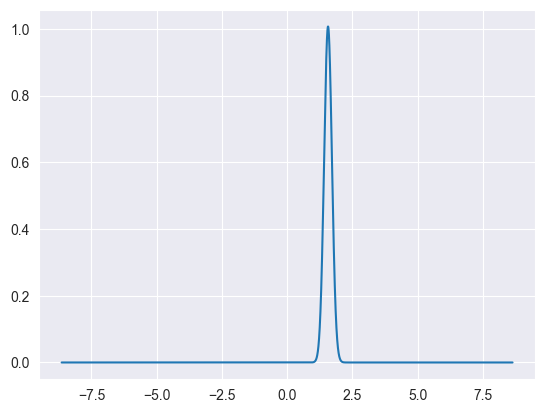

In [65]:
import matplotlib.pyplot as plt
x = np.linspace(-5*np.abs(obs_tar), 5*np.abs(obs_tar), 10000)
plt.plot(x, np.exp(sel_probs))

In [66]:
np.max(np.exp(sel_probs))

np.float64(1.007306466894858)

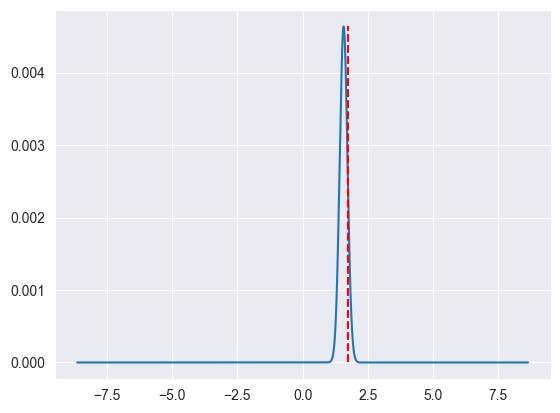

In [67]:
plt.plot(x, dist.pdf(theta=norm_contrast.dot(mu)))
plt.vlines(obs_tar, ymin=0, ymax=np.max(dist.pdf(theta=norm_contrast.dot(mu))),
           linestyles='--', colors='grey')
plt.vlines(norm_contrast.dot(mu), ymin=0, 
           ymax=np.max(dist.pdf(theta=norm_contrast.dot(mu))),
           linestyles='--', colors='red')

In [68]:
dist.ccdf(theta=norm_contrast.dot(mu), x=obs_tar)

np.float64(0.148274432367154)

In [69]:
pval

np.float64(0.09668858666965492)

In [70]:
float("1")

1.0

In [71]:
(x > obs_tar).sum()

np.int64(4000)

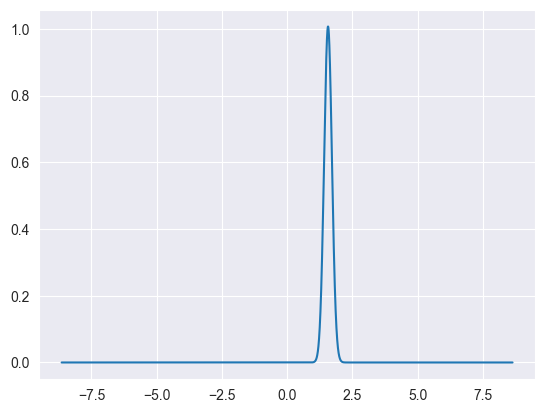

In [72]:
plt.plot(x, np.exp(sel_probs))

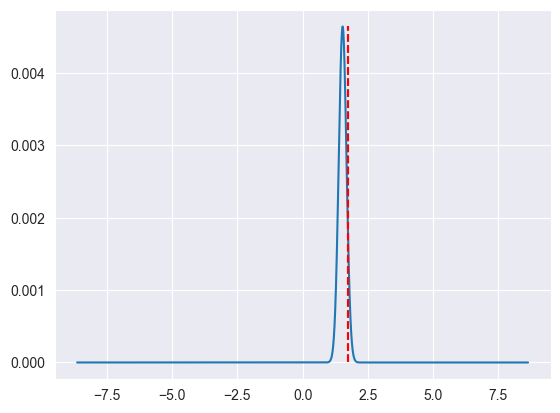

In [73]:
plt.plot(x, dist.pdf(theta=0))
plt.vlines(obs_tar, ymin=0, ymax=np.max(dist.pdf(theta=0)),
           linestyles='--', colors='grey')
plt.vlines(norm_contrast.dot(mu), ymin=0, 
           ymax=np.max(dist.pdf(theta=0)),
           linestyles='--', colors='red')

In [74]:
def root_inference_sim(n = 50, p = 5, a = 0.1, b = 0.1, 
                       sd_y = 1, noise_sd = 1, start=0, end=100):
    pivots = []
    naive_pivots = []
    for i in range(start, end):
        print(i, "th simulation")
        X = np.random.normal(size=(n, p))

        mu = b * ((X[:, 0] <= 0) * (1 + a * (X[:, 1] > 0) + (X[:, 2] * X[:, 1] <= 0)))
        y = mu + np.random.normal(size=(n,), scale=sd_y)
        # Create and train the regression tree
        reg_tree = RegressionTree(min_samples_split=20, max_depth=2,
                                  min_proportion=0.)
        reg_tree.fit(X, y, sd = noise_sd * sd_y)
        
        #if not reg_tree.root.left.left:
        #    continue
        """pval, dist, contrast, norm_contrast, obs_tar, logW, suff, sel_probs\
            = (reg_tree.condl_split_inference(node=reg_tree.root, ngrid=10000,
                                              ncoarse=100, grid_width=15,
                                              reduced_dim=1, sd=sd_y,
                                              use_cvxpy=True))"""
        
        pval, dist, contrast, norm_contrast, obs_tar, logW, suff, sel_probs \
            = (reg_tree.condl_node_inference(node=reg_tree.terminal_nodes[0],
                                             ngrid=10000,
                                             ncoarse=50,
                                             grid_w_const=5,
                                             reduced_dim=None,
                                             sd=sd_y,
                                             use_cvxpy=True))
        
        target = norm_contrast.dot(mu)
        pivot_i = dist.ccdf(theta=target, x=obs_tar)
        pivots.append(pivot_i)
        
        naive_pivot = Z_test(y=y, norm_contrast=norm_contrast, 
                             null=target)
        naive_pivots.append(naive_pivot)
    
    return pivots, naive_pivots

In [75]:
t1 = time()
pivots_50, naive_pivots_50 \
    = root_inference_sim(start=0, end=100, n=50,
                         sd_y=2, noise_sd=0.5, 
                         a=1,b=1)
t2 = time()

0 th simulation
integral: -175.00986592122388
marginal: -3020.8080616025163
integral: -177.48615105060756
marginal: -2761.5130955796226
integral: -179.45639016011972
marginal: -2522.363299152147
integral: -180.80093158164732
marginal: -2301.893138596726
integral: -181.4169215693859
marginal: -2098.7112589994917
integral: -181.21830429983984
marginal: -1911.5004842560347
integral: -180.1358218718213
marginal: -1739.0178170714503
integral: -178.11701430645152
marginal: -1580.0944389602992
integral: -175.1262195471598
marginal: -1433.6357102466263
integral: -171.14457345968418
marginal: -1298.6211700639624
integral: -166.17000983207123
marginal: -1174.1045363553203
integral: -160.21726037467548
marginal: -1059.2137058731869
integral: -153.31785472016065
marginal: -953.1507541795336
integral: -145.52012042349838
marginal: -855.1919356458111
integral: -136.88918296196917
marginal: -764.6876834529612
integral: -127.50696573516174
marginal: -681.0626095913967
integral: -117.47219006497316
mar

(array([ 9.,  7., 11., 11., 14.,  8.,  9., 12., 14.,  5.]),
 array([0.0060163 , 0.10244602, 0.19887573, 0.29530545, 0.39173517,
        0.48816488, 0.5845946 , 0.68102431, 0.77745403, 0.87388375,
        0.97031346]),
 <BarContainer object of 10 artists>)

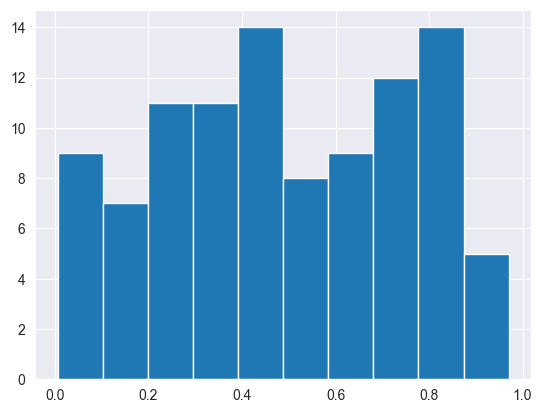

In [76]:
plt.hist(pivots_50, bins=10)

(array([28.,  2.,  9.,  5.,  7.,  9.,  4.,  8.,  8., 20.]),
 array([5.45037476e-06, 9.99724477e-02, 1.99939445e-01, 2.99906442e-01,
        3.99873440e-01, 4.99840437e-01, 5.99807434e-01, 6.99774431e-01,
        7.99741429e-01, 8.99708426e-01, 9.99675423e-01]),
 <BarContainer object of 10 artists>)

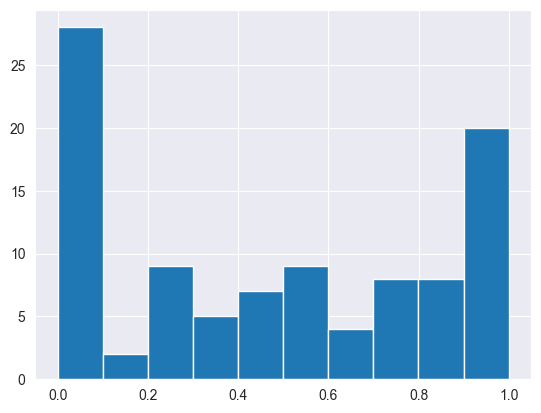

In [77]:
plt.hist(naive_pivots_50, bins=10)

In [78]:
def plot_ecdf(data):
    # Step 2: Sort the data
    data_sorted = np.sort(data)

    # Step 3: Calculate the empirical CDF
    # For each point, the CDF value is the proportion of data points less than or equal to that point
    cdf_values = np.arange(1, len(data_sorted) + 1) / len(data_sorted)

    # Step 4: Plot the empirical CDF
    plt.figure(figsize=(6, 6))
    plt.step(data_sorted, cdf_values, where='post', label='Empirical CDF')
    plt.title('Empirical Cumulative Distribution Function')
    # Add a y=x line
    plt.plot(data_sorted, data_sorted, label='Uniform CDF', linestyle='--')
    plt.xlabel('Data Points')
    plt.ylabel('CDF')
    plt.grid(True)
    plt.legend()
    plt.show()

def plot_ecdfs(data_list, labels, title=None):
    # Step 2: Sort the data
    sorted_data = []
    for data in data_list:
        data_sorted = np.sort(data)
        sorted_data.append(data_sorted)

    # Step 3: Calculate the empirical CDF
    # For each point, the CDF value is the proportion of data points less than or equal to that point
    cdf_values = np.arange(1, len(data_sorted) + 1) / len(data_sorted)

    # Step 4: Plot the empirical CDF
    plt.figure(figsize=(6, 6))
    for i, data in enumerate(sorted_data):
        plt.step(data, cdf_values, where='post', 
                 label=labels[i])
    if not title:
        plt.title('Empirical Cumulative Distribution Function')
    else:
        plt.title(title)
    # Add a y=x line
    plt.plot(data_sorted, data_sorted, label='Uniform CDF', linestyle='--')
    plt.xlabel('Data Points')
    plt.ylabel('CDF')
    plt.grid(True)
    plt.legend()
    plt.show()


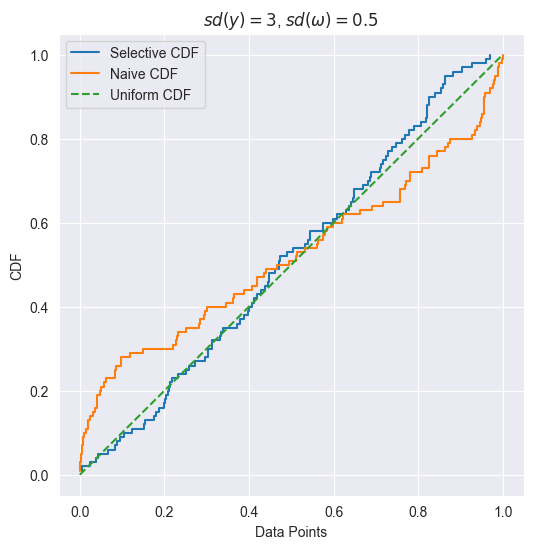

In [79]:
plot_ecdfs([pivots_50, naive_pivots_50], ["Selective CDF", "Naive CDF"],
           title="$sd(y)=3$, $sd(\omega) = 0.5$")